In [29]:
import pandas as pd
import numpy as np
import sqlite3
import csv
from pathlib import Path
import matplotlib.pyplot as plt


# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [45]:
# Connect to the SQLite database
base_dir = Path.cwd().parent
data_base_file_path = base_dir/"db.sqlite3"
absolute_data_base_file_path = data_base_file_path.resolve()

connection = sqlite3.connect(absolute_data_base_file_path)
cursor = connection.cursor()

query = '''
SELECT 
    restaurant_order.id,
    restaurant_order.datetime,
    restaurant_product.name,
    restaurant_product.price,
    restaurant_orderitem.quantity 

FROM restaurant_orderitem

INNER JOIN restaurant_order 
ON restaurant_orderitem.order_id = restaurant_order.id

INNER JOIN restaurant_product
ON restaurant_product.id = restaurant_orderitem.product_id
'''

# Execute the query and fetch all rows
cursor.execute(query)
rows = cursor.fetchall()

csv_file_name = "restaurant_data.csv"
csv_file_path = base_dir/csv_file_name
absolute_csv_file_path = csv_file_path.resolve()

# Write the data to a CSV file
try:
    with open(absolute_csv_file_path, "w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["order_id", "order_date", "product", "price", "quantity"])
        writer.writerows(rows)
    
    print(f"Data has been successfully written to {csv_file_name}.\n")

except Exception as e:
    print(f"Error: Data wasn't written to {absolute_csv_file_path}.")
    print(f"Exception: {e}")

finally:
    if connection:
        connection.close()
        print("Database connection closed.")

data = pd.read_csv(absolute_csv_file_path)
print(data)


Data has been successfully written to restaurant_data.csv.

Database connection closed.
       order_id           order_date                product  price  quantity
0             1  2019-08-03 20:25:00          Plain Papadum   0.80         2
1             1  2019-08-03 20:25:00       King Prawn Balti  12.95         1
2             1  2019-08-03 20:25:00            Garlic Naan   2.95         1
3             1  2019-08-03 20:25:00          Mushroom Rice   3.95         1
4             1  2019-08-03 20:25:00    Paneer Tikka Masala   8.95         1
...         ...                  ...                    ...    ...       ...
74813      3255  2016-05-18 18:53:00    House Red wine 75cl  17.95         2
74814     12905  2016-05-14 19:28:00    House Red wine 75cl  17.95         2
74815      3272  2016-05-10 13:18:00    House Red wine 75cl  17.95         2
74816     11404  2016-04-07 19:04:00  House white wine 75cl  17.95         1
74817     11449  2015-10-02 17:29:00    House Red wine 75cl  17.9

# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

In [ ]:
def autopct_format(pct: float, allvals: list) -> str:
    """Function to show both percentage and quantity in the pie chart"""
    absolute = int(round(pct/100.*sum(allvals)))
    return "{:.1f}% ({:d})".format(pct, absolute)

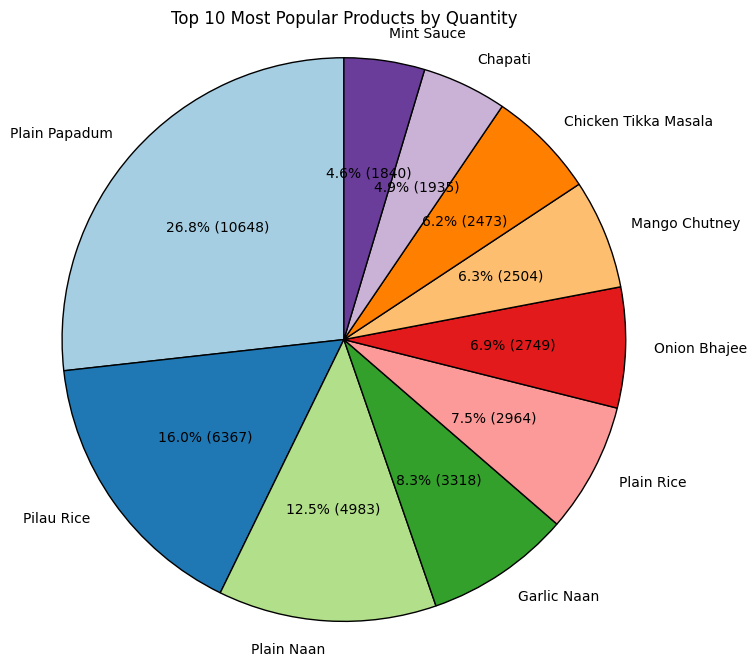

In [48]:
products = data.groupby("product")["quantity"].sum().reset_index()
products = products.sort_values(by="quantity", ascending=False)
top_10_products = products.head(10)

plt.figure(figsize=(8, 8))
plt.pie(
    top_10_products["quantity"], 

    labels=top_10_products["product"], 
    autopct=lambda pct: autopct_format(pct, top_10_products["quantity"]), 
    startangle=90, 
    colors=plt.cm.Paired.colors, 
    wedgeprops={"edgecolor": "black"},
)

plt.axis("equal")
plt.title("Top 10 Most Popular Products by Quantity")
plt.show()


# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

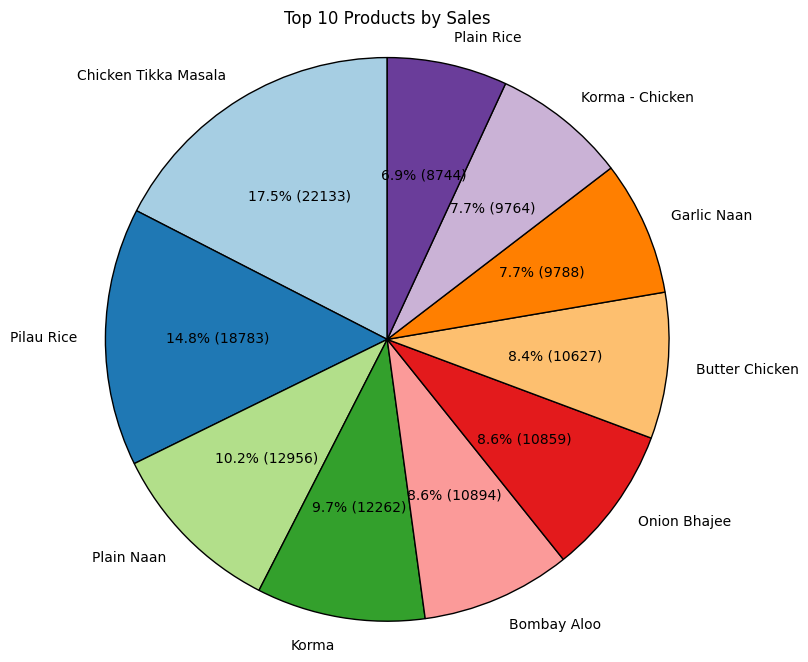

In [54]:
data["item_price"] = data["price"] * data["quantity"]
sales_by_product = data.groupby("product")["item_price"].sum().reset_index()
sales_by_product = sales_by_product.sort_values(by="item_price", ascending=False)
top_10_sales = sales_by_product.head(10)

plt.figure(figsize=(8, 8))
plt.pie(
    top_10_sales["item_price"], 
    labels=top_10_sales["product"], 
    autopct=lambda pct: autopct_format(pct, top_10_sales["item_price"]), 
    startangle=90, 
    colors=plt.cm.Paired.colors, 
    wedgeprops={"edgecolor": "black"},
)

plt.axis("equal")
plt.title("Top 10 Products by Sales")
plt.show()

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

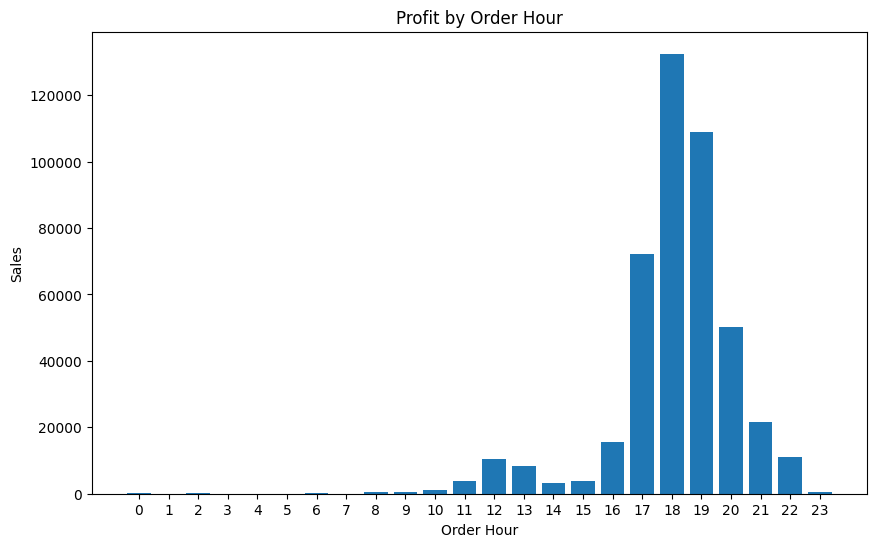

In [67]:
data["order_hour"] = data["order_date"].str[11:13].astype(int)
income_per_hour = data.groupby("order_hour")["item_price"].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(income_per_hour["order_hour"], income_per_hour["item_price"])
plt.xticks(range(24))
plt.title("Profit by Order Hour")
plt.xlabel("Order Hour")
plt.ylabel("Sales")
plt.show()


# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

In [ ]:
# write your code here